In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 416
batchsize = 32
COLORS = 3

In [6]:
Freshness_Data = tf.keras.preprocessing.image_dataset_from_directory(
    "Meat Freshness Data",
    shuffle=True,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size= batchsize
)

Found 2266 files belonging to 3 classes.


In [7]:
class_names = Freshness_Data.class_names

In [8]:
def split_for_train_test(ds, training = 0.8, validation = 0.1, testing = 0.1, shuffle=True, shufflesize = 10000):
    size = len(ds)
    train = int(size* training)
    temp = size - train
    val = int(validation*size)
    if shuffle:
        ds = ds.shuffle(shufflesize, seed = 12)
    
    
    train_ds = ds.take(train)
    remain = ds.skip(train)
    val_ds = remain.take(val)
    test_ds = remain.skip(val)
    
    return train_ds, val_ds, test_ds


In [10]:
train_ds, val_ds, test_ds = split_for_train_test(Freshness_Data)

In [11]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

56
7
8


In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),#to take care of any image that is not 256 * 256
    layers.experimental.preprocessing.Rescaling(1.0/255)
    
])
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),#see video about data augmentation
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [18]:
n_classes = len(class_names)
shape = (batchsize,IMAGE_SIZE,IMAGE_SIZE,3)

model = models.Sequential([#models is a function of keras see top cell
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=shape),#(3,3) in every layer.Conv2D is kernal_size read from website
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=shape),
    layers.MaxPooling2D((2,2)),
    
    
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape = shape)

In [19]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
EPOCHES = 10
history = model.fit(
    train_ds,
    epochs = EPOCHES,
    batch_size=batchsize,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
56/56 [==============================] - 540s 10s/step - loss: 0.4465 - accuracy: 0.8024 - val_loss: 0.4897 - val_accuracy: 0.7706
Epoch 2/10
56/56 [==============================] - 519s 9s/step - loss: 0.4164 - accuracy: 0.8298 - val_loss: 0.5037 - val_accuracy: 0.7936
Epoch 3/10
56/56 [==============================] - 486s 9s/step - loss: 0.3660 - accuracy: 0.8460 - val_loss: 0.5312 - val_accuracy: 0.8165
Epoch 4/10
56/56 [==============================] - 421s 8s/step - loss: 0.3868 - accuracy: 0.8292 - val_loss: 0.5566 - val_accuracy: 0.7844
Epoch 5/10
56/56 [==============================] - 420s 7s/step - loss: 0.3917 - accuracy: 0.8371 - val_loss: 0.4485 - val_accuracy: 0.8073
Epoch 6/10
56/56 [==============================] - 417s 7s/step - loss: 0.3465 - accuracy: 0.8539 - val_loss: 0.3801 - val_accuracy: 0.8670
Epoch 7/10
56/56 [==============================] - 417s 7s/step - loss: 0.3016 - accuracy: 0.8740 - val_loss: 0.4727 - val_accuracy: 0.8028
Epoch 8/10
5

In [42]:
score = model.evaluate(test_ds)

8/8 [==============================] - 13s 2s/step - loss: 0.2835 - accuracy: 0.8760


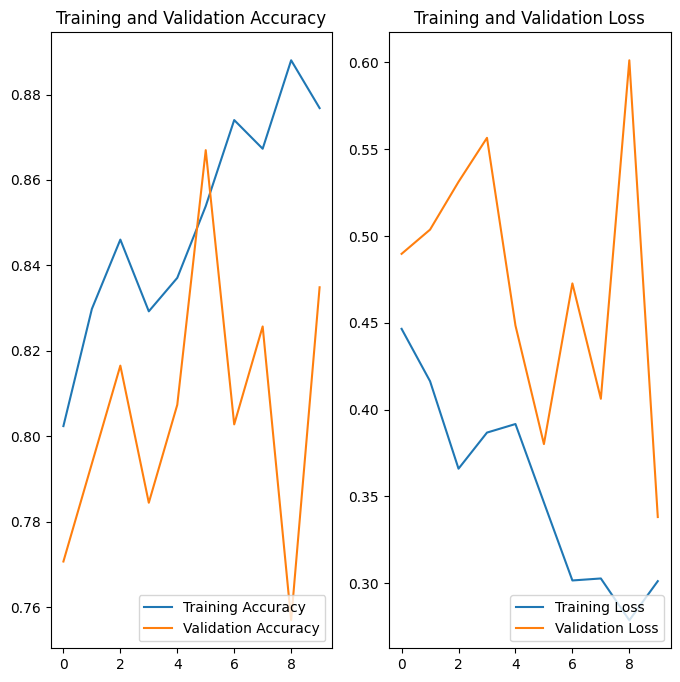

In [34]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHES),history.history['accuracy'],label='Training Accuracy')
plt.plot(range(EPOCHES),history.history['val_accuracy'],label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title("Training and Validation Accuracy")


plt.subplot(1,2,2)#change the last parameter for another graph
plt.plot(range(EPOCHES),history.history['loss'],label='Training Loss')
plt.plot(range(EPOCHES),history.history['val_loss'],label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.title("Training and Validation Loss")
plt.show()

1/1 [==============================] - 1s 1s/step
Percentage correct:  100.0  %


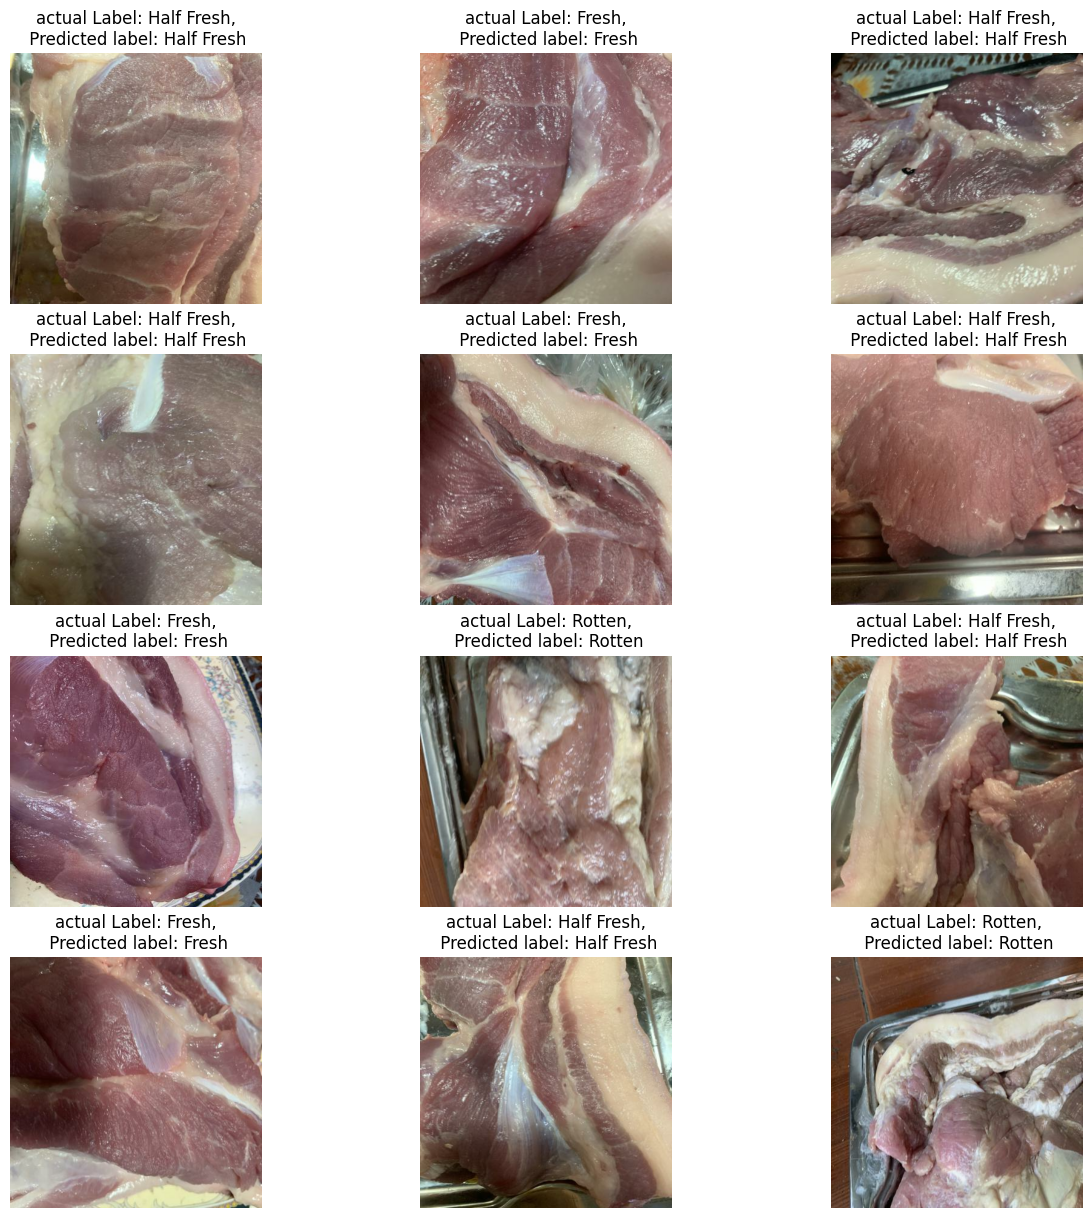

In [40]:
import numpy as np
from sklearn.metrics import classification_report
plt.figure(figsize=(15,15))
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    #print("image to predict")
    #plt.imshow(first_image)
    #print("actual Label: ",class_names[first_label])
    batch_prediction = model.predict(images_batch)#note that the model is built to predict an entire batch(32 images)
    #so we need to predict entire batch first
    #print("Predicted label: ",class_names[np.argmax(batch_prediction[0])])
    rang = 12 # max is 32 because batch size is 32
    copy = rang
    for i in range(rang):
        ax = plt.subplot(4,3,i+1)#3 rows and 3 column
        plt.axis('off')
        first_image = images_batch[i].numpy().astype('uint8')
        first_label = labels_batch[i]
        plt.imshow(first_image)
        if class_names[first_label]!=class_names[np.argmax(batch_prediction[i])]:
            copy -=1
        #print("actual Label: ",class_names[first_label])
        #print("Predicted label: ",class_names[np.argmax(batch_prediction[i])])
        plt.title(f"actual Label: {class_names[first_label]},\n Predicted label: {class_names[np.argmax(batch_prediction[i])]}")
    print("Percentage correct: ",float(copy/rang)*100," %")

In [41]:
model_version = '2(more Trained)'
model.save(f'../models/{model_version}')

INFO:tensorflow:Assets written to: ../models/2(more Trained)\assets


INFO:tensorflow:Assets written to: ../models/2(more Trained)\assets


### Confusion Matrix